In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

In [3]:
def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, sweep_radsius):
    
  #sweep_radsius = 0.2
  #num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)
    
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    
    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  only_distances = distance_cum_index[:,0]
  print(only_distances)
  where_is_it = np.where( only_distances < sweep_radsius ) 
  print('where_is_it', where_is_it)  
  print('where_is_it[0][-1]', where_is_it[0][-1])
  num_neighbours = where_is_it[0][-1] +1
  
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)
  
  #print("The shape of A is ")
  #print(A.shape)
  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  print(next_barycenter)  
  return A, next_barycenter, remaining_indices,num_neighbours


In [4]:
def get_convergent_barycenters(point_cloud, initial_pt,sweep_radsius):   
    
    #no_neighbours = int(point_cloud.shape[0] / no_of_barycenetrs_required)
    #initiating no of neighbours
    #no_neighbours = 5
    
    #num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)

    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) == 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary


        print('rem_indices before', rem_indices)
        neighbours, bary, rem_indices, no_neighbours = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, sweep_radsius)
        print('no_neighbours', no_neighbours)

        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


        print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance < 0.000001):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            #rem_indices = rem_set
            rem_indices = rem_indices[no_neighbours:]

            #print("Sampled barycenters are")
            #print(sampled_barycenters)
            #no_neighbours = 5
            print('rem_indices',rem_indices)
            print("len(rem_indices)",len(rem_indices))
            if(len(rem_indices) ==0):
                break
            bary = point_cloud[rem_indices[0]]
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


# Torus in 3D

In [7]:
x, y, z = sp.symbols('x y z')


In [8]:
## Torus
R = 1.5
r = 0.7
expr_torus = (x**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*(x**2 + y**2)


In [9]:
expr_torus

-9.0*x**2 - 9.0*y**2 + 3.0976*(0.568181818181818*x**2 + 0.568181818181818*y**2 + 0.568181818181818*z**2 + 1)**2

In [10]:
poly_torus = sp.Poly(expr_torus, x, y, z)

In [11]:
sp.expand(expr_torus)

1.0*x**4 + 2.0*x**2*y**2 + 2.0*x**2*z**2 - 5.48*x**2 + 1.0*y**4 + 2.0*y**2*z**2 - 5.48*y**2 + 1.0*z**4 + 3.52*z**2 + 3.0976

In [12]:
#Convert sympy polynomial to minterpy polynomial

newt_poly_torus = sympy_to_mp(poly_torus, mp.NewtonPolynomial)

# Trials on Torus : 

In [13]:
#Sample points on the zero isocontour
def points_on_torus(num_points):
    
    point_data_torus = sample_points_on_poly(num_points,        # Number of points to be sampled
                                       newt_poly_torus,  # Polynomial in Newton basis
                                       bounds=3.0, # Boundary of the Cubic domain to be sampled
                                       tol=1e-15)  # Tolerance in solution
    
    return point_data_torus

# 1. 1000 barycenters from 10000 points

In [14]:
#Sample points on the zero isocontour

point_data_torus = sample_points_on_poly(1000,        # Number of points to be sampled
                                   newt_poly_torus,  # Polynomial in Newton basis
                                   bounds=3.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [15]:
point_data_torus.shape

(1000, 3)

In [16]:
x_t = point_data_torus[:,0]
y_t = point_data_torus[:,1]
z_t = point_data_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# demo of barycenter convergence on a torus


In [17]:
torus_bary = get_convergent_barycenters(point_data_torus, point_data_torus[0],0.4)

rem_indices before [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241

[0.03122362 0.04480594 0.1059184  0.10779051 0.10780305 0.23097787
 0.23242842 0.24161448 0.27136424 0.27960659 0.35234107 0.35334106
 0.41390944 0.45779542 0.49936817 0.52849867 0.53311586 0.53376843
 0.54713992 0.56689323 0.57797293 0.59342587 0.61202199 0.6446723
 0.66171667 0.67875476 0.70348288 0.7092036  0.72916378 0.74428929
 0.76102608 0.76680883 0.77225097 0.79178705 0.80906094 0.82467212
 0.83564686 0.84117365 0.84332604 0.85193582 0.85314572 0.85397772
 0.85966362 0.86060494 0.86846333 0.89182014 0.89803831 0.9016639
 0.90655693 0.93239731 0.93960978 0.94244359 0.94604344 0.95481879
 0.95704437 0.95939635 0.96099262 0.96866151 0.99290058 0.99393672
 1.00173563 1.00617567 1.00987262 1.02571388 1.04847734 1.04928291
 1.05838127 1.05925269 1.06375178 1.07254003 1.0727894  1.07380291
 1.07601405 1.07670289 1.0844097  1.08733296 1.09947929 1.10415167
 1.10630102 1.10781196 1.112248   1.1149743  1.12498749 1.1366176
 1.13678772 1.14232202 1.16447227 1.16610912 1.17265299 1.1846897

[0.09393008 0.12989359 0.14093482 0.14734871 0.15753569 0.16637089
 0.20916613 0.22427711 0.24254428 0.32472104 0.34743587 0.40269322
 0.49301784 0.50131714 0.5057297  0.51175666 0.52200542 0.55984497
 0.5745408  0.59455725 0.62246119 0.66177557 0.66311957 0.68946758
 0.69529499 0.71462639 0.71656538 0.71769012 0.7255425  0.72856137
 0.74524367 0.75690808 0.78960026 0.81565954 0.81789758 0.83312532
 0.83783077 0.83943911 0.869091   0.87992042 0.88965988 0.89036661
 0.89934818 0.90015855 0.91000806 0.91022005 0.91295991 0.92566861
 0.9269754  0.93479297 0.93548009 0.93727468 0.94046552 0.94515212
 0.94709905 0.95766706 0.95819141 0.96493106 0.96967545 0.97571227
 0.97661868 0.99014671 0.99555795 0.99907992 1.00474495 1.00783247
 1.01423965 1.01437113 1.01671479 1.02100327 1.02832196 1.03908919
 1.05112497 1.05245415 1.05898292 1.06820662 1.07241989 1.07262581
 1.07556586 1.09022023 1.09594143 1.10092208 1.10199301 1.10523503
 1.11249417 1.12058603 1.12282905 1.12961181 1.13214614 1.1389

[0.1123834  0.12066298 0.20171222 0.22675954 0.24686931 0.25045978
 0.26461489 0.29353271 0.29784566 0.31200567 0.38263692 0.42931858
 0.44094549 0.44617267 0.4575493  0.48554883 0.49309429 0.4948574
 0.51291873 0.51678661 0.52389612 0.53603867 0.54945142 0.56758342
 0.57192356 0.59060918 0.60061062 0.62035831 0.63680794 0.64043495
 0.64186411 0.65007414 0.65714035 0.66303023 0.67169798 0.68059708
 0.68933546 0.69184765 0.70295354 0.70637695 0.71538179 0.71637754
 0.72419613 0.73690763 0.77813371 0.78699726 0.78722998 0.7999477
 0.80403133 0.81398886 0.81734348 0.82684612 0.83254046 0.86031787
 0.8797906  0.89471843 0.89833695 0.91931162 0.94034268 0.97012447
 0.97928437 0.98397413 0.98577646 1.03436024 1.03679226 1.03712484
 1.04191947 1.0526915  1.05532814 1.06567489 1.06612218 1.06642028
 1.07968991 1.08262225 1.08986243 1.09838632 1.10661545 1.11490357
 1.11869556 1.12134318 1.13722532 1.14318778 1.14625456 1.15539378
 1.15755355 1.15903018 1.16015144 1.16298878 1.16992978 1.171438

rem_indices [889 488 749 808 857 128 167 775 516 735 562 912 530 501 189 564 719 245
 553  77 168 847 253 797 907 418 412  32  37 146 868 200 141  26 557 891
 968 705  14   4 334 298 451  34 459 446  88 683 878  13 655 316 600 697
 546 333 242  16 577 585 397 911 884 204 339 565 931 914 952 625 545 867
 603 661 209 633 360 743 456 351 531 350 280 940 580 385 807 343 132 219
  52 549  93 834 709 313 324 858 226 406 306 721 382 447 353 589 935 542
 852 672 538 361 190 876  71 612 819 839 755 438 786 331  42 685 526 892
 944 359 213 119 533 152 130 134 738 620 277 348 784 174  72  80 308 816
 522 938 920  75 802 436 699 302 246  20 294 265 400 995 811 926 932 355
 305 980 416 933 303 519 135 622 366 264 846 422 206 860 934 818 541 435
 644 726 273 744 693 262 930 187 260 803 123 824 768 239  30 626 405 991
 921  17 480 781 957 905 498 918 263 959 728 354 939 986 108 588 367 244
 692 270 650 747 326 869 799 537 125 357 976 393 149  68 936 116 376 469
 665 628 336 552 725 981 250 241 472 84

[0.         0.09252594 0.29061308 0.34019684 0.36728278 0.36940218
 0.39734893 0.41042284 0.41719505 0.43054864 0.4675453  0.4744611
 0.48573592 0.51923634 0.52059377 0.52362733 0.53013033 0.53237482
 0.5425185  0.5446318  0.59475749 0.62060206 0.6301468  0.64677787
 0.66516807 0.69802229 0.73555802 0.73561088 0.74246171 0.74291951
 0.75139203 0.75234273 0.76600048 0.76693873 0.77474254 0.78499257
 0.78604093 0.78845856 0.80019819 0.8023975  0.80280406 0.81497675
 0.81905477 0.82328797 0.83473002 0.83907643 0.84613714 0.8504692
 0.86914076 0.87201719 0.87334316 0.87822399 0.88026249 0.88912833
 0.89718164 0.90148646 0.90554951 0.91211989 0.91888461 0.92623611
 0.92876843 0.93581145 0.93819981 0.94118492 0.95308921 0.95988285
 0.96339798 0.96716018 0.97797146 0.97998603 0.98981063 0.99054151
 0.99239273 0.99508729 0.99951518 1.00652706 1.00654384 1.01541077
 1.01971468 1.02220914 1.02999988 1.03103651 1.04364979 1.05757754
 1.06355249 1.06830597 1.0684236  1.07401516 1.10082512 1.113957

[0.10595405 0.1761757  0.1926172  0.20041553 0.20056992 0.21135091
 0.2176123  0.2228272  0.25222316 0.29103274 0.30869674 0.35491209
 0.46294267 0.46910687 0.53173525 0.53174011 0.53961601 0.55679788
 0.57273936 0.57773499 0.57807566 0.58178335 0.58297494 0.5847358
 0.60276207 0.60385739 0.61832206 0.62823407 0.63151548 0.63952512
 0.63998361 0.64150469 0.64252891 0.65501807 0.65889589 0.66650573
 0.67209899 0.67278438 0.67461258 0.70293563 0.72050795 0.74753976
 0.75038908 0.75917439 0.76977847 0.77455315 0.77645801 0.78693832
 0.80075575 0.8034014  0.80393655 0.81907717 0.82182089 0.82255577
 0.82846174 0.83081718 0.83316734 0.83491198 0.84263629 0.8535945
 0.85939752 0.87856979 0.88070787 0.88635206 0.90556441 0.91404779
 0.92623347 0.93273257 0.94615435 0.9472927  0.95964429 0.96233017
 0.97795401 0.99310282 1.00380504 1.00681505 1.02056778 1.02793502
 1.03175671 1.03242991 1.03344003 1.03823582 1.04204872 1.04449639
 1.0483955  1.05038604 1.05228726 1.05315934 1.06612888 1.072785

[0.09483724 0.16726471 0.20391308 0.20825496 0.21499994 0.25852057
 0.28419748 0.32073021 0.33464269 0.36318671 0.37856229 0.4090376
 0.42024291 0.43803127 0.45438677 0.45753078 0.45872024 0.46573842
 0.47852965 0.48463337 0.4931737  0.50480257 0.54438289 0.55761125
 0.57752284 0.6141657  0.62155675 0.63255858 0.64175368 0.65270018
 0.65532733 0.66427777 0.66678086 0.67235303 0.68205564 0.69051572
 0.70625511 0.70752756 0.73032946 0.74416183 0.76270003 0.774209
 0.77698265 0.79025445 0.8122724  0.81851036 0.84087011 0.8427376
 0.8450611  0.84777783 0.8510004  0.85616185 0.85932559 0.86047449
 0.89219229 0.89494382 0.90966595 0.92372985 0.926208   0.94831147
 0.95842706 0.96982039 0.97643367 0.99081707 0.99651194 0.99740374
 1.0207183  1.02600144 1.02711616 1.02714241 1.0324802  1.05027175
 1.05246705 1.05969721 1.05999581 1.06820469 1.07114    1.08480515
 1.09095443 1.10293087 1.10530149 1.10563907 1.11079151 1.11255251
 1.12001746 1.14187871 1.14702445 1.14868175 1.15764104 1.17253542

[0.13573732 0.22628259 0.22651172 0.2634256  0.35515338 0.35804858
 0.39871384 0.43310702 0.49395266 0.50100355 0.51014632 0.52590584
 0.53042758 0.53872076 0.54835512 0.5506122  0.55478118 0.55768402
 0.56039602 0.5651015  0.58607546 0.59435661 0.64466844 0.64860319
 0.69445547 0.7528729  0.75473301 0.80237821 0.80798045 0.81911695
 0.8191783  0.83370166 0.84854137 0.86758602 0.86944614 0.87187015
 0.87304952 0.88670775 0.88951438 0.89559042 0.90702531 0.90761988
 0.92277762 0.92987044 0.9428568  0.96240051 0.96815898 0.97945114
 1.0114219  1.01327235 1.01605052 1.01773266 1.02779121 1.05442446
 1.05579865 1.05692373 1.0910435  1.09260756 1.10385213 1.1092178
 1.11113501 1.12884886 1.13920275 1.1421422  1.14970623 1.15586819
 1.16771394 1.17169226 1.1789163  1.18287269 1.19939417 1.19974728
 1.20221683 1.20373671 1.21105232 1.21434289 1.217775   1.21955088
 1.22142243 1.22318497 1.22708482 1.22903425 1.22915477 1.23338617
 1.24421886 1.2467862  1.24772276 1.24967071 1.26132775 1.26303

[0.10194733 0.1213748  0.14101625 0.15395216 0.16202325 0.16990139
 0.17849985 0.18797966 0.22491087 0.25470596 0.29570959 0.2976967
 0.34359912 0.41006255 0.42760506 0.43439453 0.44913454 0.47128312
 0.47271904 0.5506641  0.56911308 0.57115341 0.60226759 0.60259757
 0.61023625 0.61198324 0.61400795 0.62999049 0.6477183  0.65529861
 0.68031593 0.69107091 0.69509972 0.69606801 0.69774268 0.71136258
 0.76424682 0.774443   0.7832559  0.79241371 0.80638388 0.81029144
 0.85271425 0.86617416 0.90277646 0.90922887 0.91310114 0.91768675
 0.94556238 0.94572058 0.95366223 0.9577551  0.96350538 0.96772294
 0.99529723 1.00653409 1.00943649 1.01458664 1.02452294 1.02991028
 1.03104617 1.05920118 1.06001524 1.06671391 1.07798494 1.08383022
 1.08765175 1.10038322 1.10342681 1.10523165 1.10816468 1.10887444
 1.11652101 1.11673466 1.12165151 1.1263537  1.13105509 1.15519906
 1.15744019 1.15865655 1.1598656  1.16988996 1.17426539 1.17490824
 1.17634002 1.17651474 1.17653039 1.179932   1.18061889 1.18363

[0.10525685 0.18066454 0.19206488 0.19263823 0.25511999 0.25523743
 0.29951918 0.34617619 0.35058206 0.37657576 0.38925651 0.39561981
 0.42077883 0.422241   0.46314815 0.54067118 0.54784997 0.54799772
 0.572626   0.58037022 0.59711966 0.61799885 0.62847649 0.64210092
 0.64892035 0.65259993 0.67956951 0.68022368 0.68551887 0.70174027
 0.71803945 0.71877238 0.72160902 0.72266763 0.72443564 0.74106565
 0.74701436 0.75195795 0.75793872 0.77190872 0.77793332 0.78447348
 0.78580788 0.78977964 0.80104871 0.80318594 0.8285121  0.8342678
 0.83559439 0.8379357  0.85285834 0.85465443 0.85822247 0.86924625
 0.87221861 0.87807779 0.87968904 0.89499965 0.90164081 0.90193982
 0.90628494 0.92063426 0.92382989 0.93783739 0.9500786  0.95394501
 0.95908496 0.97161326 0.97350642 0.97416792 0.97723691 0.98003731
 0.98109126 0.98582279 0.98739338 0.9880522  0.99255299 1.00229109
 1.00448727 1.00617445 1.00770208 1.01332246 1.02113904 1.0222071
 1.02637084 1.03585445 1.03881936 1.03886012 1.04174513 1.042646

[0.110311   0.12738418 0.17643294 0.18129005 0.21965866 0.23421021
 0.24997787 0.25158824 0.2661856  0.28468005 0.30153284 0.30210241
 0.30599977 0.32027963 0.32865845 0.34926448 0.35081536 0.37348924
 0.39413065 0.43134746 0.43582132 0.44211969 0.46377993 0.47032507
 0.49555626 0.50829516 0.51565235 0.52011589 0.52835711 0.53482809
 0.55217726 0.55383892 0.55434478 0.55549902 0.5632103  0.59209461
 0.59617522 0.60367598 0.60616494 0.61251527 0.61271583 0.61564241
 0.64549187 0.65598515 0.67468907 0.68799065 0.68946451 0.69479166
 0.70084892 0.70529006 0.70962197 0.71206906 0.7131278  0.71418051
 0.72970336 0.73126047 0.74382389 0.76319022 0.78673505 0.79023114
 0.80107203 0.81272933 0.81848494 0.82073974 0.84294485 0.84821932
 0.85987453 0.86409545 0.87296031 0.87778135 0.90028012 0.90102854
 0.91413172 0.91548845 0.91945207 0.91948733 0.93487651 0.93863463
 0.94500924 0.94514842 0.95199811 0.96185017 0.96834993 0.96932795
 0.98433417 0.98808301 0.99060658 1.0056922  1.01129711 1.0157

[0.08167733 0.10982386 0.12372582 0.15043041 0.15273119 0.20194867
 0.23533558 0.24385171 0.3165909  0.33338618 0.39746472 0.39851842
 0.40064072 0.40731194 0.42799692 0.43118248 0.43829411 0.45780857
 0.46717988 0.46826092 0.51948747 0.60849604 0.61117716 0.64184686
 0.64296859 0.65727325 0.67788442 0.69159283 0.69552454 0.69679405
 0.70010569 0.74103165 0.7581525  0.76169592 0.78763274 0.812315
 0.81695824 0.85808116 0.8745368  0.88608113 0.93621971 0.94685461
 0.95353595 0.96081188 0.98042832 0.98624129 1.00255075 1.00441313
 1.00992599 1.01028767 1.01201239 1.01303878 1.02808372 1.04067865
 1.04926412 1.06003903 1.07268502 1.09973162 1.10634957 1.1380294
 1.14810246 1.15816013 1.15976488 1.16911933 1.17649432 1.17651152
 1.18005498 1.182995   1.19006654 1.19725602 1.19757913 1.19763421
 1.19814727 1.20165611 1.20237532 1.20671044 1.20720643 1.20936099
 1.21168863 1.21676427 1.23899744 1.24002796 1.24452346 1.25015537
 1.25294624 1.25317895 1.26052308 1.26213462 1.26553027 1.2694439

no_neighbours 4
Tracking distance between new barycenter and previous barycenter :  0.21837123229498218
rem_indices before [105 909 787 289 113 486 664 582 632 862 762 344 993  87 972 453 641 627
 657 617 982 413  85 963 165 474 458 866 584 403  63 631 536 676 318 525
 327 283 347 247 636 711 502 572 419 410 166 987  50 942 964 745 364 325
 362  83 779 508 203 566 544   8 576  11 687 671 714 563 236 801 774  31
 157 386  58 962 256 465 639 319 452 875  55  79 335 551 153 271 999 663
 765  82 487 950 163 194 890 151 417 658 481 983 978 384  78 297 887  10
 679 871 330 196 669 424 984 992 249  53 777 997 967 270 647 437 341 411
 301 496 859 363 913 588 841 285 205  60  28 444 595 939 668  22 309 517
 842 159  39 199 261 622 315 773 811 990 423 680 856 733 626 469 587 225
 119 359  41 130 910  56 179  75 112 605 703 482 713 724 338 579 223 538
 672 654 737 643 827 428 547 529 896 470 684 429 121 807 832 461 524 696
 929 149 776 322 921 463 772 839 139 820 674 892 810 519 406 206 395 770
 

[0.0443743  0.05395282 0.07820213 0.0973848  0.09854575 0.15235577
 0.17326051 0.19636107 0.19697657 0.20982616 0.22564716 0.26164021
 0.27002192 0.28430741 0.31718728 0.34735969 0.35842036 0.39807952
 0.40364447 0.40425358 0.41579023 0.43794438 0.49224502 0.49974834
 0.52379353 0.54371735 0.55171942 0.57836656 0.6238864  0.63926378
 0.63943476 0.65222689 0.68246677 0.70608659 0.71230066 0.73705758
 0.74954182 0.75616395 0.76157792 0.76371181 0.7780801  0.77830747
 0.79195054 0.79846334 0.79985431 0.80388118 0.81793861 0.83120629
 0.83501568 0.86660065 0.87117017 0.87720019 0.88630591 0.90173335
 0.91464727 0.92521805 0.9481575  0.95202556 0.97634679 0.98503096
 1.02172254 1.04817355 1.0516644  1.0802945  1.0908763  1.10664695
 1.13181518 1.13567627 1.13742393 1.14136158 1.15113468 1.15523092
 1.16692966 1.17892427 1.18194031 1.20141361 1.20768808 1.21535044
 1.2260613  1.23373918 1.2364948  1.24216815 1.2481414  1.272945
 1.27407442 1.27473673 1.27616378 1.30357043 1.3046465  1.306105

[0.08409692 0.09109341 0.13924748 0.14453435 0.14563538 0.17021229
 0.1710616  0.17293379 0.1788609  0.20501038 0.22773458 0.26050833
 0.28570579 0.29634953 0.29997534 0.30048727 0.30357369 0.30742244
 0.33226328 0.35041059 0.43551263 0.45402043 0.46229721 0.48196892
 0.5098228  0.52225156 0.53813038 0.5729024  0.57697157 0.59832173
 0.62166658 0.62400303 0.64837327 0.65393769 0.6550461  0.66667844
 0.67405784 0.67570594 0.71332854 0.72912328 0.74539733 0.75749494
 0.77987643 0.7932321  0.80391155 0.80559353 0.81436628 0.8152644
 0.82701523 0.8309069  0.84169211 0.87194952 0.87438717 0.87505483
 0.87539158 0.88533075 0.89120979 0.91076232 0.91748206 0.92502319
 0.9265876  0.92776555 0.92845532 0.93118135 0.93441413 0.93830736
 0.93955319 0.94265655 0.94852214 0.9500744  0.95121791 0.95154856
 0.95796552 0.96701451 0.96809373 0.97162164 0.98453402 1.0014274
 1.01090344 1.01456355 1.01529262 1.02768258 1.03045839 1.03163755
 1.03225672 1.05634823 1.06045287 1.06125509 1.06863508 1.070597

where_is_it[0][-1] 11
[-1.05937486  0.09654274 -0.52571549]
no_neighbours 12
Tracking distance between new barycenter and previous barycenter :  0.02983923682737417
rem_indices before [418 350 661 204 564 530 459 697 298 775 603 589 200 683 501 488 625 868
 306 451 709 516 995 313 246  34 456 876 803 816 847 187 253 526 250 986
 533 565 818 846 277 416 936 436 382 596 940 920 303 447 853  37 891 926
 446 911 106 633 397 938 797 168 114 905 884 928 351  17 108 102  14 729
   4 955 537 854 935 858 629 375 665 116  80 291  52 834 981 650 798 219
 863 728 143 795 128 207 513 104 864 209 531 872 980 399 888 546 226 772
 134 190 686 336 857 889 968 976 214 276 334 125 562  68 717 302 337 281
 577 422 628 262 552 768 903 492 127 255 600 507 738   9 961 264   5 467
 585 580 719 241 434 741 316 691  95 292 815 555 392 930 141 796 455 133
 432 730 498 284 346 747 601 360 907 477 781 273 780 323 355 602 240  74
 843 561 208 952 951 556 170 739 227 844 838 101 267 509 282 874 778 193
 595 895 545 

 684 667 827 576  85 524 896 636 223 866 982  63 587 225 413 199 341]
len(rem_indices) 521
rem_indices before [955 106 798 872 729 928 818 104 108 905 537 665 717 864  17 277  95 863
 281 350 207 399 650 601 143  74 629 843 382 276 728 838 741 240 455 739
 170 565 589 940 556 227 895 874 976 467 246 603 961 432 267 291 492 101
   5  80 633 298 208 434 775 530 346 625 911 351 564 282 986 193 397 936
 392 884 847 682 253 509 241 868 451 501   9 796 320 691 730 175 488 815
  52 888 134 526  37 780 258 127 533 951 851 284 262 561 722 436 516 844
 846 425 416 920 555 303 778 926 255 226 352 520 747 190 133 155 214 477
 292  14 602 336 938 447 903 624 264  68 552 628 125 930 904 686 660 653
 433 981 781 528 662 230 173 103 372 369 273 513 980 935 540 858 378 795
 290 198 446 891 116 211 817 323 559 768 681 491 498 834 337 732 422 219
 829 560 507 302 723 266 499 772 970 586 328 797 183   4 886 216 511 168
 531 573 599 209 252 716 708 407 738 439 900 355 340 710  70 956 546 295
 441  64 512 3

[0.05007745 0.05818528 0.08012158 0.09454384 0.10999272 0.1612698
 0.23213613 0.26429935 0.26943578 0.27611097 0.28317876 0.30305227
 0.32018225 0.34438528 0.40521065 0.42689839 0.42894751 0.43092686
 0.47463037 0.47471599 0.48477219 0.51215503 0.52985785 0.58580183
 0.60499963 0.60946669 0.70394266 0.74447397 0.79545614 0.8130682
 0.83163541 0.83682656 0.84769591 0.85790051 0.85847728 0.87574717
 0.87748759 0.8957894  0.89701347 0.92110105 0.92177488 0.94968012
 0.9531773  0.98455828 1.0381356  1.07664524 1.09098386 1.10346528
 1.10713017 1.11806201 1.12580735 1.13280011 1.13874892 1.14454069
 1.15430184 1.16327085 1.16883346 1.19631051 1.19754838 1.20185121
 1.2073931  1.21392681 1.22888404 1.23740068 1.24150943 1.24930034
 1.25534317 1.26050999 1.26262333 1.33659447 1.33673558 1.33725286
 1.33927393 1.34963236 1.35389357 1.37013207 1.37495477 1.38120782
 1.42181267 1.42520106 1.44749297 1.46753052 1.47023377 1.47291283
 1.47494085 1.48448972 1.48707348 1.48753192 1.49038728 1.513104

 696 988 667  85 684 576 636 524 896 866 225 982  63 223 413 587 341 199]
[0.08187836 0.09976022 0.16174224 0.2050301  0.20923951 0.24349729
 0.27125553 0.28059438 0.29342658 0.35825821 0.36072978 0.36594454
 0.39423236 0.41341326 0.4855227  0.52473209 0.53143168 0.57739158
 0.58615908 0.59342158 0.6021417  0.60227113 0.62342898 0.63728857
 0.6386473  0.65889354 0.66353014 0.67894647 0.707771   0.73098543
 0.73466893 0.73769622 0.75608351 0.75955873 0.7599099  0.77236877
 0.77676768 0.79702621 0.80139808 0.82654515 0.84092364 0.84329547
 0.84953999 0.86489259 0.88759818 0.90111392 0.90152614 0.94737511
 0.96212261 0.96777612 0.98496237 0.98701843 0.98901219 1.00581054
 1.01351309 1.01934229 1.02582975 1.04193044 1.0421012  1.04301258
 1.05187141 1.0551813  1.05627251 1.05690038 1.0626827  1.06549494
 1.06991436 1.07547114 1.1002147  1.10367167 1.11281163 1.11800898
 1.13544481 1.13925893 1.1732507  1.17477684 1.17609471 1.18102503
 1.18616264 1.18630582 1.1866044  1.19678659 1.19912861

[0.07191743 0.09254911 0.1101359  0.14383798 0.15196419 0.22236942
 0.23451839 0.2357811  0.33527125 0.3384107  0.49194452 0.5078792
 0.52042916 0.52842291 0.55079832 0.5520557  0.56024861 0.56264046
 0.56361675 0.57666689 0.59906896 0.60286957 0.63963921 0.69694583
 0.71110776 0.71395307 0.73017658 0.73944827 0.7524032  0.75919672
 0.76648875 0.76757356 0.79808133 0.81846257 0.82338086 0.83553713
 0.85758279 0.87819349 0.89953334 0.90294006 0.93270401 0.95136161
 0.95527993 0.95945561 0.99341424 1.00569118 1.00791978 1.01190193
 1.01336186 1.02233324 1.0275668  1.05425915 1.06745519 1.07343811
 1.07995313 1.08070435 1.0879795  1.1049466  1.10699075 1.1107528
 1.11510377 1.11878145 1.12995753 1.13148893 1.13153393 1.13757502
 1.14176886 1.14321731 1.14376011 1.14435841 1.15032549 1.15970207
 1.1609868  1.18277651 1.18615982 1.1871479  1.19991343 1.21987127
 1.22890307 1.23014781 1.24097616 1.24297522 1.24463921 1.24467247
 1.24467426 1.25228789 1.25889981 1.26795742 1.2682265  1.271291

[0.         0.06738533 0.15369014 0.19150666 0.1995489  0.29355914
 0.30651446 0.33347814 0.35992856 0.39192487 0.40860495 0.43646859
 0.45460724 0.49123923 0.54729993 0.55715498 0.6096072  0.6113875
 0.64768621 0.6827381  0.68849167 0.69049907 0.70522428 0.71674334
 0.73149407 0.74961998 0.79078954 0.79877519 0.85772223 0.86189556
 0.8696763  0.87420868 0.87752133 0.88532902 0.88666231 0.89598778
 0.90702275 0.90813102 0.90989366 0.93149714 0.9531093  0.95950875
 0.99504732 1.00312683 1.01990876 1.03824829 1.06197481 1.11375436
 1.13696804 1.14180838 1.15819569 1.16372857 1.2143255  1.27255752
 1.41722565 1.41767886 1.41861142 1.43730669 1.44014429 1.46864582
 1.48512818 1.51371528 1.51545399 1.52522637 1.52548654 1.53157439
 1.53866932 1.54910714 1.55547066 1.57960581 1.58980428 1.63015677
 1.6351552  1.64051214 1.64664853 1.70643204 1.71230574 1.72236655
 1.74679396 1.7503126  1.76780117 1.77801998 1.80005994 1.81155507
 1.82287553 1.82344795 1.8346255  1.85762492 1.89908701 1.90717

[0.08386424 0.14557884 0.2082596  0.29977671 0.40542283 0.42515438
 0.46380597 0.4691991  0.50049353 0.52107375 0.52475459 0.6490627
 0.65447433 0.68760796 0.76028542 1.10624567 1.11682464 1.14143732
 1.14652618 1.23054273 1.23173027 1.26757886 1.28322373 1.29520823
 1.29840084 1.30330769 1.32819292 1.34136686 1.35784254 1.38502496
 1.40154177 1.40554256 1.40574976 1.40632907 1.4326923  1.43779154
 1.45761061 1.46425063 1.47048695 1.47517842 1.4794484  1.49724324
 1.50653863 1.51562135 1.53084139 1.53389732 1.53546988 1.5623652
 1.57027851 1.58718298 1.58833724 1.60453107 1.62075372 1.63471023
 1.63605878 1.64113651 1.66988193 1.67719715 1.71643104 1.71839755
 1.73658036 1.80432923 1.84833353 1.88805778 1.91743963 1.9311951
 1.94122251 1.96149939 1.9947406  2.0113756  2.01446449 2.02456865
 2.07028161 2.08044503 2.08679145 2.09803201 2.09824424 2.10255127
 2.10867453 2.11043566 2.11986029 2.12070578 2.12215489 2.13748977
 2.1427912  2.15217183 2.15498287 2.16541816 2.16860206 2.1691288

rem_indices before [595 984 910 153 663 157 671 247 502 410 403 318 327 779 362 508 687 801
 236 639 942 745 774 714 929 461 962 574  41   8  31 163 371 470 417 737
 424 261  50 859  58 423 419 654 646 270 330 428 463 521 812  78 993 572
 233 997 196 342 325 658 999 501 464 100 493 707 516 849 939 256  11 943
 964 978 510 350 793 564 938 396  97 584 631 458  65 453 970 212 922 627
 821 679 829 842 716 885 283 626 257 530 347 411 598 559 708 168 797  89
 488 900 782 358 252 128 710 356 141 676 817 562 216 198 775 907 301 290
 857 681  70 441  64 903 886 407 249 315 333 499 511 719 599 179 586  56
 159  39 372 211 528 990 889 103 433 660 653 624 536 425 520 733 722 851
 992 682 843 838  85 579 895 982 847 101  95 227 866 739 413  74 253 170
 556  63 636 481 576 240 601 818 565  37 277 725 872 382 940 729 741 717
 911 281 905 397 108 633  14  17 884 537 351 467 665 864 863 796 961 207
 434 477 650 341   5 728 284  80  52 199 696 684 587 492 223 976 226 896
 225 134 190 241 524 747 262 264

[0.09910041 0.10643027 0.20882451 0.21466354 0.483163   0.50334795
 0.53445006 0.5519804  0.63624335 0.63884684 0.66959442 0.67980971
 0.70858545 0.72789778 0.74385225 0.74771471 0.75209788 0.81394738
 0.83299102 0.84296178 0.8767463  0.89204186 0.89815265 0.95233771
 0.99113439 1.0069105  1.05083064 1.06405972 1.10029331 1.12426893
 1.13694293 1.14814275 1.19141869 1.20838168 1.26042774 1.30886483
 1.35344    1.36843314 1.37524806 1.37788716 1.38091646 1.40143343
 1.46046634 1.46511608 1.49038235 1.60726748 1.61153283 1.65208744
 1.65964545 1.69563168 1.69656176 1.72161096 1.81256408 1.81637911
 1.82108767 1.83815732 1.84083817 1.84280556 1.84695819 1.85626314
 1.88114403 1.89589795 1.90274418 1.91079184 1.91885699 1.95030785
 1.95215686 1.96847525 1.98006896 1.98552642 1.99833598 2.01675777
 2.02052925 2.06446831 2.06631989 2.08675298 2.09553529 2.12903448
 2.20924665 2.24331612 2.26762356 2.28276127 2.28685603 2.30033883
 2.31823047 2.34986372 2.37119661 2.37400022 2.42040408 2.4237

[ 1.22105577 -1.72552188  0.31886249]
no_neighbours 6
Tracking distance between new barycenter and previous barycenter :  0.041521367546673585
rem_indices before [584 631 458 627  11 453 993 942 745 536 812  85 982 233 413 866  63 636
 576 992 481 938 341 579 903 141 333 199 907 516 501 168 797 587 128 562
 350 564 225 857 223 719 684 896 530 696 488 524 889 775 725 667 847 253
 741 872 717 818 281 565  37 277 467 729 382 940 796 477 905 961 434 108
 864 911 537  17   5  14 397 284 665 633 884 863 351 207 492 650 728  80
  52 241 976 226 747 134 190 262 781 264 930 273 435]
[0.03445359 0.06612076 0.07551441 0.1481657  0.20760684 0.23846423
 0.65775003 1.77700993 1.78488069 1.83021617 1.92157179 1.9251099
 1.93291835 1.99463078 2.00047396 2.04154771 2.069278   2.14880992
 2.23488691 2.52383968 2.54595787 2.76597085 2.78335548 2.80592041
 2.85008589 2.85272687 2.85430607 2.85887505 2.90027806 2.91871929
 2.92270941 2.92603671 2.92758566 2.93333018 2.94068933 2.95681852
 2.96391965 2.9813

In [18]:
torus_bary.shape

torch.Size([107, 3])

In [19]:
# plotting the sampled barycenters

x_stb = torus_bary[:,0]#.cpu().detach().numpy()

y_stb = torus_bary[:,1]#.cpu().detach().numpy()

z_stb = torus_bary[:,2]#.cpu().detach().numpy()



plot_points = [x_stb,y_stb,z_stb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Trajectory of barycenter smpling


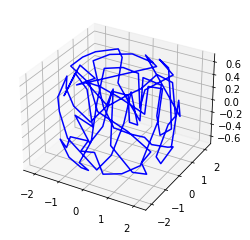

In [20]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = torus_bary[:,0]
Y = torus_bary[:,1]
Z = torus_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

# Persistent homology of sampled barycenters

/tmp/ipykernel_14778/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


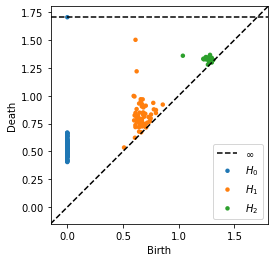

In [21]:
torus_PH_arrays,PH_diagram_barycenters_torus = get_persistence_diagram(torus_bary,2)

# Persistent homology of original points

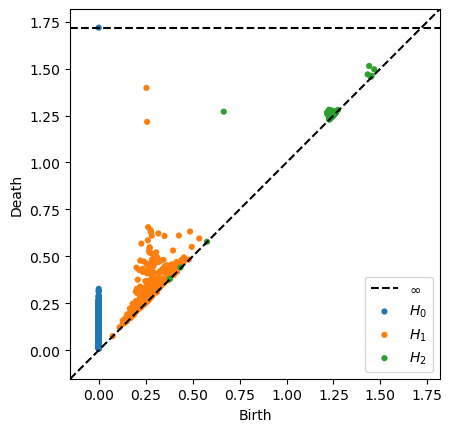

In [22]:
torus_PH_arrays_ori,PH_diagram_ori_torus = get_persistence_diagram(point_data_torus,2)

# observation

The persistent homology signatures are very similar but the sacles at which births and deaths occur are different. The birth and death values in PH of barycenters are higher than their counterparts in original points cloud. The same has to be eperimented on image datasets

# Sphere

In [23]:
expr = x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr, x, y, z)

In [24]:
expr

x**2 + y**2 + z**2 - 1

In [25]:
    # convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)

In [36]:
#sample points
point_data = sample_points_on_poly(500,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [37]:
point_data.shape

(500, 3)

In [38]:

x_so = point_data[:,0]

y_so = point_data[:,1]

z_so = point_data[:,2]


plot_points = [x_so,y_so,z_so]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [39]:
sphere_bary = get_convergent_barycenters(point_data, point_data[0], 0.4)

rem_indices before [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241

[-0.49958942 -0.60262502  0.56144467]
no_neighbours 33
Tracking distance between new barycenter and previous barycenter :  0.0
rem_indices [ 55 196  13 156  77 386 498 111  72 330   1 437 268   5  48 470 478 340
 400 411 295 283 358 365 142 321 318 306 253  51 397 182 270  93 201 416
 304 286 174  99 221  11  12  68  69 107  90 485 209 368 476 163  67  28
 258 149  78 392  89 434   3 235 477 376  24 355 364 101 447 236 362 287
 341 113  98 499 446 398 104 211 467   6 481 492 118 363 440 249 410 219
 179 491 420  25 154 175 266 308 130 432 354  86 216 158 242 345 178  45
 453 324 192  60 469 454 109 448 429  27 195 157 250 415 445 279 102 438
 139  35  39  65 493 145 346  57 233 160 251  40  20 230 361 273 103 197
 314 461 430 181 153  63  58 292 105 372 300 204 210 396  15  22  62 299
 227 353 176  30 373 245 208 123  50 131   8 462 450 406 404 203 180  66
 352 172 370 474 212  54 187 137 387 382 405 436 468 310 350 339 155 433
 150 296 224 247  43 106 177 313  47  42 170 428 431 294 2

[0.11679681 0.13390322 0.14069093 0.15381082 0.16890629 0.18269004
 0.19192546 0.21598371 0.26194979 0.27975899 0.28324139 0.29759936
 0.30090332 0.32044109 0.34158562 0.34742694 0.35105465 0.36250553
 0.3976767  0.40354742 0.42810843 0.44687821 0.48076659 0.48866029
 0.5020684  0.50668679 0.50873795 0.53070064 0.53594382 0.57240352
 0.58011796 0.58032812 0.59504882 0.60201188 0.60241131 0.6145926
 0.61468988 0.62391409 0.63359384 0.64106178 0.64125945 0.64638316
 0.65595749 0.66079456 0.66812212 0.68575207 0.6952119  0.69578103
 0.69606459 0.73504088 0.73690664 0.74105302 0.74341552 0.74573548
 0.75250107 0.75314476 0.75812144 0.77244749 0.7833798  0.7840767
 0.78810279 0.79453869 0.79856096 0.80350644 0.80750586 0.82032689
 0.82837401 0.83065515 0.8330977  0.83918569 0.84142147 0.85423804
 0.85435424 0.85867167 0.8622964  0.86292718 0.86815967 0.87242266
 0.88342001 0.88463118 0.92203901 0.92379629 0.93232725 0.94410201
 0.94462808 0.95051331 0.95360438 0.95517218 0.95540288 0.961856

[0.07362266 0.11925209 0.12541774 0.15483254 0.17063016 0.25016013
 0.25418989 0.26875272 0.2735196  0.27716469 0.28039699 0.28068164
 0.2827931  0.30320001 0.32828118 0.33929829 0.35113432 0.35223253
 0.36432823 0.36448237 0.38178542 0.38720612 0.39407514 0.39838692
 0.40492993 0.41812342 0.44781332 0.45401741 0.46230586 0.47194262
 0.47794323 0.49256063 0.51635806 0.51965456 0.53851465 0.54365597
 0.54745147 0.5492201  0.55124912 0.55215978 0.56976128 0.5907914
 0.5912587  0.60616672 0.63943659 0.64671795 0.65559121 0.6676339
 0.67603686 0.70323224 0.70911133 0.72389488 0.73361746 0.75368107
 0.76093209 0.76424535 0.76486434 0.76990812 0.78424835 0.80169739
 0.8050559  0.81474403 0.81529722 0.82395307 0.82798952 0.83673382
 0.83952657 0.85727171 0.8771714  0.88427599 0.88577621 0.89662775
 0.89900349 0.92389034 0.94040121 0.94213122 0.94217139 0.9629367
 1.00757295 1.01031433 1.01664329 1.01916805 1.03303733 1.03539581
 1.04383382 1.05334311 1.05856687 1.06927697 1.07385996 1.0752104

[0.04578153 0.0928588  0.10071934 0.13571153 0.19144034 0.22947481
 0.232314   0.24791154 0.25764744 0.27879699 0.31237706 0.31950855
 0.35326036 0.36555134 0.420842   0.42355013 0.43378172 0.44819371
 0.45857091 0.47094497 0.48153732 0.48219345 0.5070939  0.51236107
 0.51897723 0.52581179 0.52820213 0.54217973 0.54600828 0.54777525
 0.55195    0.56125197 0.56408282 0.56585531 0.58956759 0.5901553
 0.59732829 0.60341342 0.60478364 0.61847454 0.62295211 0.63168373
 0.65511297 0.65579969 0.66629987 0.67228482 0.67466608 0.67604931
 0.69210352 0.71873198 0.7246916  0.72482405 0.72813129 0.74176519
 0.76382631 0.76386694 0.7706665  0.77484195 0.78014867 0.80451166
 0.81920843 0.82433908 0.83537445 0.83670592 0.84348473 0.8613083
 0.8614345  0.88522395 0.93058966 0.94087073 0.94104884 0.97945656
 0.98197182 0.9886766  1.00250835 1.01172002 1.01215148 1.01613051
 1.02039239 1.02656204 1.04700499 1.05566399 1.05685925 1.05734396
 1.05868415 1.07106743 1.0718721  1.08486148 1.08662869 1.110895

[0.06820842 0.07425704 0.09506464 0.12216591 0.18245671 0.20234316
 0.20512902 0.20752655 0.2111884  0.21955255 0.27061715 0.31549571
 0.40286027 0.44927868 0.46227164 0.51732533 0.54959531 0.55407469
 0.59564654 0.60108357 0.60199758 0.61150969 0.61443172 0.62353994
 0.62582311 0.65893881 0.67107842 0.67892894 0.68076545 0.6831602
 0.68453651 0.68642953 0.69773206 0.69889117 0.70249472 0.70796335
 0.73500619 0.74929984 0.75216189 0.75473196 0.75705074 0.76842764
 0.77123848 0.78892688 0.80338957 0.81779362 0.82427034 0.8321809
 0.84040155 0.85185519 0.8527046  0.86167572 0.89254121 0.91596006
 0.92906341 0.94777102 0.95873223 0.96129251 0.98542684 1.01641137
 1.03502054 1.03795475 1.04300148 1.04527112 1.04888539 1.06222059
 1.07296171 1.10736047 1.11661646 1.12178503 1.12356829 1.1479716
 1.21196487 1.21449712 1.23219564 1.23528804 1.24319646 1.24847712
 1.24875387 1.25255835 1.25306598 1.25577269 1.27647515 1.27812401
 1.29655159 1.30454363 1.30698338 1.31570433 1.3217583  1.3284547

[0.04420236 0.09774788 0.12918126 0.17828998 0.18619192 0.186327
 0.20283403 0.20434007 0.21244851 0.29106784 0.29693368 0.31034376
 0.31577065 0.32097529 0.32114899 0.33040201 0.38825302 0.41146295
 0.41288083 0.42292812 0.43665386 0.44352374 0.45804949 0.46372897
 0.48675597 0.48818316 0.52111636 0.53479247 0.5388468  0.54004227
 0.54687164 0.54784047 0.56787641 0.5687707  0.57235736 0.58724447
 0.59294439 0.59693359 0.59702381 0.64549033 0.65121417 0.65335576
 0.65761077 0.67586062 0.68373855 0.69715602 0.7019102  0.70792882
 0.71176896 0.72472157 0.7328667  0.74858581 0.74924503 0.75078273
 0.75300564 0.7536311  0.7684395  0.76944187 0.78056939 0.82586121
 0.83938577 0.84645155 0.85951752 0.89724801 0.90664496 0.91409549
 0.94711258 0.9706939  1.00138602 1.00362229 1.00651977 1.01015868
 1.01246609 1.04370942 1.05695443 1.11718414 1.12713687 1.18268851
 1.21661898 1.34711563 1.34895218 1.37817582 1.43628122 1.44322309
 1.45252614 1.4760693  1.48546713 1.50873552 1.56151095]
where_i

In [40]:
sphere_bary.shape

torch.Size([33, 3])

# Plotting sphere barycenters

In [41]:

x_spb = sphere_bary[:,0]

y_spb = sphere_bary[:,1]

z_spb = sphere_bary[:,2]


plot_points = [x_spb,y_spb,z_spb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Trajectory of barycenter smpling on sphere


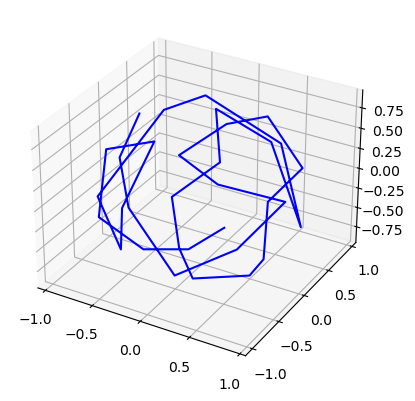

In [42]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = sphere_bary[:,0]
Y = sphere_bary[:,1]
Z = sphere_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

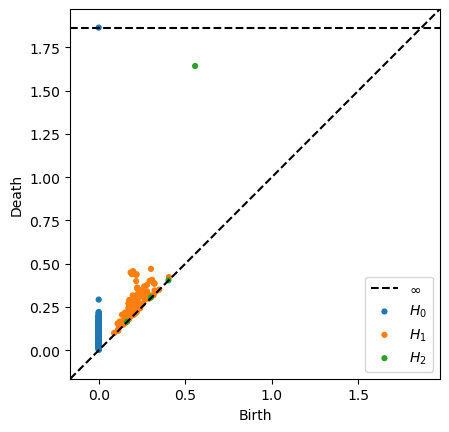

In [44]:
#original point cloud sphere persistence diagram

PH_diagram_spheres = get_persistence_diagram(point_data,2)

/tmp/ipykernel_14778/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


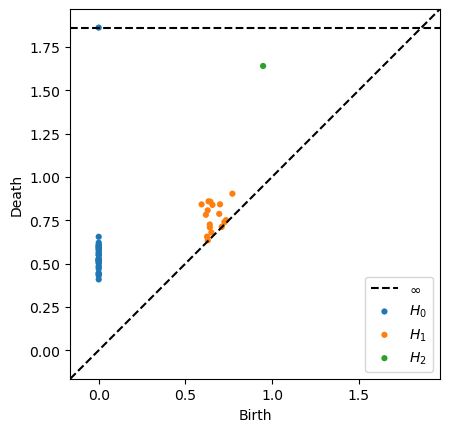

In [45]:
# barycentyers of sphere persistence diagram


PH_diagram_barycenters_sphere = get_persistence_diagram(sphere_bary, 2)